In [20]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [21]:
ROOT = './data'

train_data = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
    )

In [22]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [23]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [24]:
# plot images
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='bone')
        ax.axis('off')

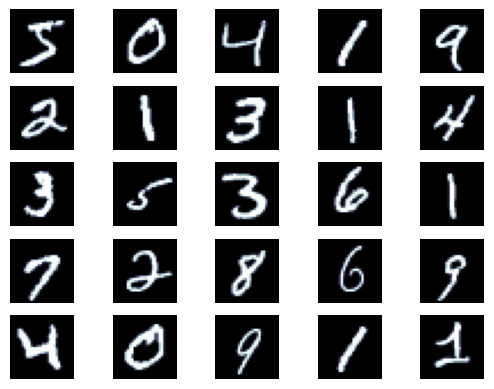

In [25]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [26]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

# compute mean and std
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

# create data loaders
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

In [27]:
inputs, labels = next(iter(train_dataloader))

In [28]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [29]:
num_classes = len(train_data.dataset.classes)
lenet_model = LeNetClassifier(num_classes)
predictions = lenet_model(inputs)

In [30]:
optimizer = optim.Adam(lenet_model.parameters())
criterion = nn.CrossEntropyLoss()
loss = criterion(predictions, labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [32]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  211 batches | accuracy    0.707
| epoch   0 |   100/  211 batches | accuracy    0.881
| epoch   0 |   150/  211 batches | accuracy    0.915
| epoch   0 |   200/  211 batches | accuracy    0.942


In [33]:
train_acc, train_loss

(0.9449685534591195, 0.47952916229505677)

In [34]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [35]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [36]:
eval_acc, eval_loss

(0.9518333333333333, 0.16793665351967016)

In [37]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.720
| epoch   1 |   100/  211 batches | accuracy    0.891
| epoch   1 |   150/  211 batches | accuracy    0.919
| epoch   1 |   200/  211 batches | accuracy    0.936
-----------------------------------------------------------
| End of epoch   1 | Time: 12.85s | Train Accuracy    0.938 | Train Loss    0.462 | Valid Accuracy    0.951 | Valid Loss    0.175 
-----------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.955
| epoch   2 |   100/  211 batches | accuracy    0.960
| epoch   2 |   150/  211 batches | accuracy    0.962
| epoch   2 |   200/  211 batches | accuracy    0.962
-----------------------------------------------------------
| End of epoch   2 | Time: 12.50s | Train Accuracy    0.964 | Train Loss    0.136 | Valid Accuracy    0.965 | Valid Loss    0.112 
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.970
| epoch   3 

In [38]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
eval_acc, eval_loss

(0.9836666666666667, 0.05774269870016724)

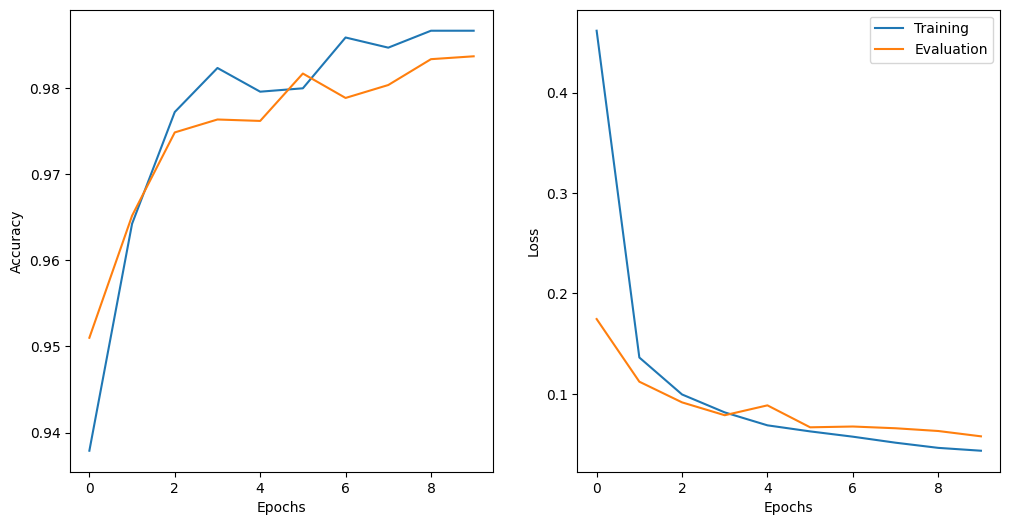

In [39]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

In [40]:
test_data.transform = test_transforms

In [41]:
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [42]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.9853, 0.04618192610105325)

In [43]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

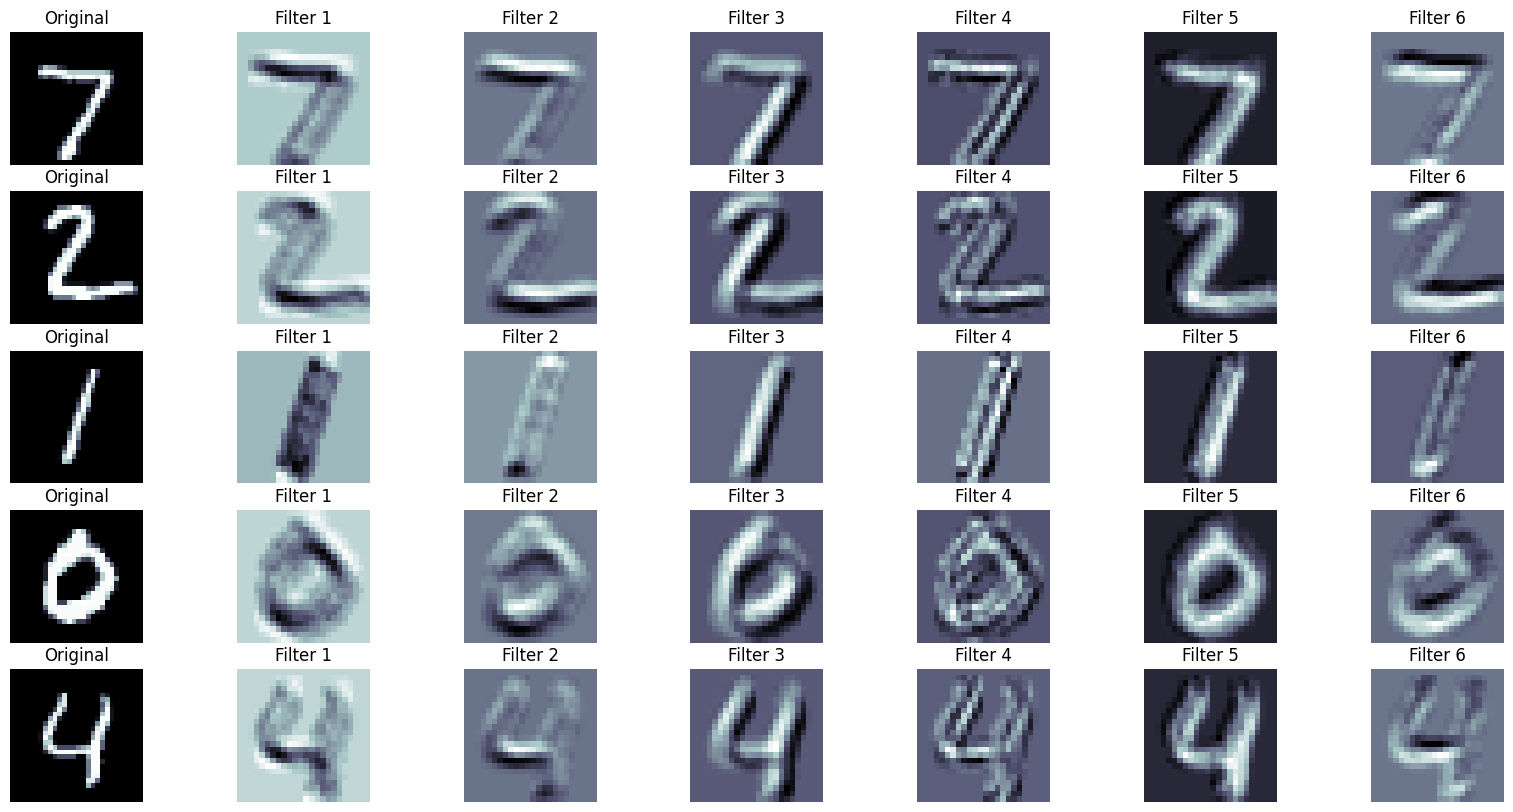

In [44]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = lenet_model.conv1.weight.data

plot_filtered_images(images, filters)

In [45]:
def load_model(model_path, num_classes=10):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    w, h = image.size
    if w != h:
        crop = transforms.CenterCrop(min(w, h))
        image = crop(image)
        wnew, hnew = image.size
    img_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])
    ])
    img_new = img_transform(image)
    img_new = img_new.expand(1, 1, 28, 28)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [47]:
model = load_model('./model/lenet_model.pt')
preds = inference('./demo_8.png', model)
preds

(0.9997280240058899, 8)